In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
with open("results/results.jsonl") as fp:
    lines = fp.readlines()
experiments = [json.loads(line) for line in lines]
results = pd.DataFrame.from_records(experiments)
results.head()

,ntasks,cumulative_time,times,launch_time,end_time,method,module,nodes,sleep,setup
0,4096,37296.710073,"[3.346970591985155, 3.201965062005911, 3.25668...",1.778835,62.471703,lazy,numpy,64,1,3.936894
1,2048,18982.994582,"[1.8026475730002858, 1.5790195030276664, 1.997...",1.036196,37.587649,lazy,numpy,64,1,1.838311
2,1024,6857.514743,"[1.9540052840020508, 1.4498477190500125, 1.500...",0.481576,20.000010,lazy,numpy,64,1,1.875432
3,512,3957.136206,"[4.271034573030192, 5.19198394898558, 5.170659...",0.270411,39.690219,lazy,numpy,64,1,1.837234
4,4096,38147.476865,"[7.03508956101723, 5.094143668015022, 6.888398...",1.957079,59.621735,lazy,tensorflow,64,1,34.710461


In [9]:
results["avg_time"] = results["times"].apply(lambda x: np.mean(x))
results["total_time"] = results["end_time"] + results["setup"]
results["tasks_per_node"] = results["ntasks"] / results["nodes"]
results.head()

,ntasks,cumulative_time,times,launch_time,end_time,method,module,nodes,sleep,setup,avg_time,tasks_per_node,total_time
0,4096,37296.710073,"[3.346970591985155, 3.201965062005911, 3.25668...",1.778835,62.471703,lazy,numpy,64,1,3.936894,9.105642,64.0,66.408597
1,2048,18982.994582,"[1.8026475730002858, 1.5790195030276664, 1.997...",1.036196,37.587649,lazy,numpy,64,1,1.838311,9.269040,32.0,39.425959
2,1024,6857.514743,"[1.9540052840020508, 1.4498477190500125, 1.500...",0.481576,20.000010,lazy,numpy,64,1,1.875432,6.696792,16.0,21.875442
3,512,3957.136206,"[4.271034573030192, 5.19198394898558, 5.170659...",0.270411,39.690219,lazy,numpy,64,1,1.837234,7.728782,8.0,41.527452
4,4096,38147.476865,"[7.03508956101723, 5.094143668015022, 6.888398...",1.957079,59.621735,lazy,tensorflow,64,1,34.710461,9.313349,64.0,94.332196


In [4]:
def plot_time_vs_tasks(nodes=1, modules=["numpy", "tensorflow"], y="avg_time"):
    for i, module in enumerate(modules):
        plt.subplot(1, len(modules), i+1)
        df = results[results["nodes"] == nodes]
        df = df[df["module"] == module]
        sns.barplot(data=df, x="ntasks", y=y, hue="method")
        plt.title(f"Module: {module}")
    plt.gcf().suptitle(f"{y} for nodes: {nodes}")

In [5]:
def plot_time_vs_nodes(tasks_per_node=1, modules=["numpy", "tensorflow"], y="avg_time"):
    for i, module in enumerate(modules):
        plt.subplot(1, len(modules), i+1)
        df = results[results["tasks_per_node"] == tasks_per_node]
        df = df[df["module"] == module]
        sns.barplot(data=df, x="nodes", y=y, hue="method")
        plt.title(f"Module: {module}")
    plt.gcf().suptitle(f"{y} for {tasks_per_node} tasks per node")

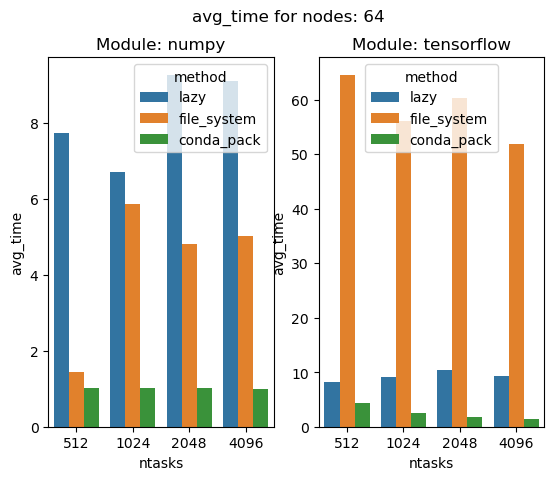

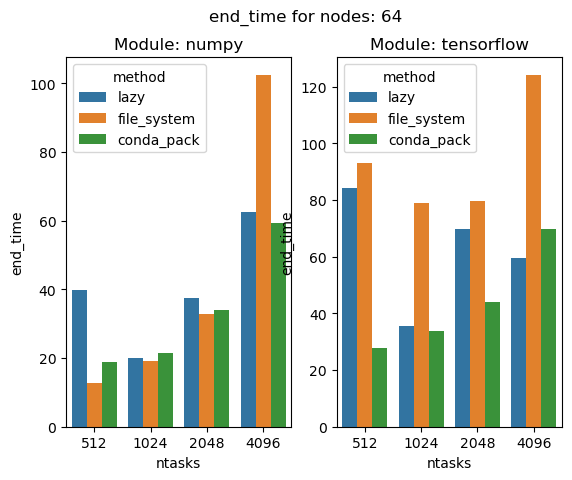

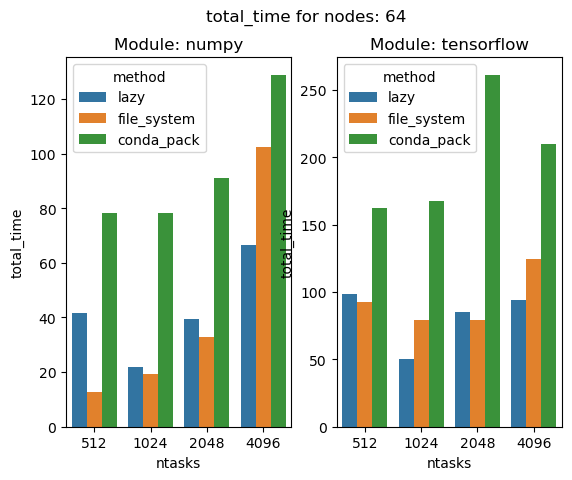

In [10]:
plot_time_vs_tasks(64)
plt.show()
plot_time_vs_tasks(64, y="end_time")
plt.show()
plot_time_vs_tasks(64, y="total_time")
plt.show()

## Thoughts
- This isn't great but it's not terrible either. We are almost equal to conda pack for several of the cases. And we exceed the file system for all of the tensorflow cases. However, it seems we slowed down since last time. I have some theories. First, we now have this double deserialization, where the method is deserialized after the parsl task starts. Second, we now are unpacking more stuff because we transfport the libraries as well as dependencies with the oringinal pack. Maybe we make a rule to only transport things when they are larger than a threshold. I also want to see what happens when the sleep time increases.
- I'm hoping we can recover some performance by using redis, so we can completely avoid the shared file system.